# Clusteranalyse

In diesem Notebook wird eine Clusteranalyse über den gesamten Datensatz, noch ohne Feature Engineering, durchgeführt. Ziel ist es, die Städte im Datensatz aufgrund ihrer Schadstoffbelastung in verschiedene Cluster einzuteilen und diese Cluster zu beschreiben.

Die Clusteranalyse verläuft rekursiv und beinhaltet auch die Identifikation und Entfernung von Städten mit extremen (realistischen und unrealistischen) Schadstoffprofilen.

Verwendet werden:
- geodatasets und geopandas für geographische Karten und Plots
- matplotlib.patches zur Individualisierung von Farbkodierungen in Plots
- sklearn für Skalierung, Clustering (K-Means) und PCA

📌 **Datenstand:** `cleaned_air_quality_data_2025-03-27.csv`  
📁 **Importiert aus:** lokaler Datei (--> gitignore)


## 📚 Inhaltsverzeichnis 
(Diese Art von Inhaltsverzeichnis mit Link funktioniert leider in Notebooks nicht, weil die as JSON gespeichert werden und nicht als HTML...)

- [0. Datensatz laden](#0-datensatz-laden)
- [1. Vollständige Schadstoffmessungen und geographische Verteilung](#1-vollständige-schadstoffmessungen-und-geographische-verteilung)
- [2. Clusterberechnung - mehrstufig](#2-clusterberechnung-mehrstufig)
- [3. Clusterbeschreibung mit PCA](#3-clusterbeschreibung-mit-pca)
- [4. Geographische Verteilung der Schadstoffcluster](#4-geographische-verteilung-der-schadstoffcluster)
- [5. Inhaltliche Interpretation](#5-inhaltliche-interpretation)


# 0. Datensatz laden

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


In [3]:
df.shape

(1695041, 23)

In [4]:
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew',
       'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [5]:
# Liste der Schadstoffvariablen
pollutants = ['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']

# 1. Vollständige Schadstoffmessungen und geographische Verteilung

Um Städte aufgrund ihrer Schadstoffbelastung sinnvoll miteinander vergleichen zu können, muss zuerst ermittelt werden, für welche Städte und Schadstoffe genügend Werte vorliegen.

In [6]:
# Anteil fehlender Werte pro Spalte
missing_ratios = df[pollutants].isna().mean().sort_values(ascending=True)

print("Anteil fehlender Werte pro Schadstoff:")
print(missing_ratios)


Anteil fehlender Werte pro Schadstoff:
Pm25    0.155129
No2     0.169031
Pm10    0.201828
O3      0.221087
So2     0.314525
Co      0.372833
dtype: float64


In [7]:
# Gruppieren: Für jede Stadt den Mittelwert je Schadstoff berechnen
city_pollution_avg = df.groupby('City')[pollutants].mean()

# Ergebnis prüfen
print(city_pollution_avg.head())


                 Co        No2         O3       Pm10       Pm25       So2
City                                                                     
Abha       5.643478   1.725641  27.278963  11.343590        NaN  2.158371
Abidjan         NaN        NaN        NaN        NaN  69.153588       NaN
Abu dhabi  0.100047  12.198529  27.726151  78.634701  97.833964  4.986937
Accra           NaN        NaN        NaN        NaN  70.522508       NaN
Adana      4.047990  11.321705  16.462533  31.463233  68.214783  4.179630


In [8]:
# Städte mit vollständigen Werten (alle 6 Schadstoffe nicht NaN)
city_pollution_complete = city_pollution_avg.dropna()
print(f"Anzahl Städte mit vollständigen Daten: {city_pollution_complete.shape[0]}")


Anzahl Städte mit vollständigen Daten: 406


Es liegen also für 406 Städte Werte für alle sechs Schadstoffe vor.

Frage: Wie verteilen sich diese Städte über die geographischen Regionen?

In [10]:

# Mittelwerte für Koordinaten je Stadt berechnen
coords = df.groupby('City')[['Latitude', 'Longitude']].mean()

# Nur die Städte mit vollständigen Schadstoffdaten behalten
coords_filtered = coords.loc[city_pollution_complete.index]



In [11]:
# GeoDataFrame mit Punkt-Geometrie
coords_filtered['geometry'] = coords_filtered.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_complete = gpd.GeoDataFrame(coords_filtered, geometry='geometry', crs='EPSG:4326')


Text(0.5, 1.0, 'Städte mit vollständigen Daten für alle sechs Schadstoffe')

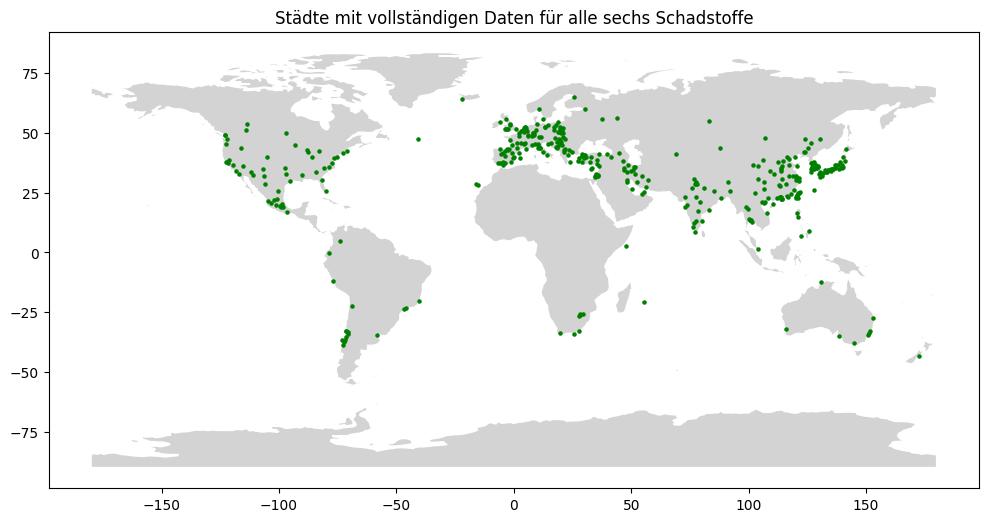

In [12]:
# Weltkarte laden
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Plot
ax = world.plot(figsize=(12, 6), color='lightgrey', edgecolor='white')
gdf_complete.plot(ax=ax, color='green', markersize=5)

ax.set_title("Städte mit vollständigen Daten für alle sechs Schadstoffe")


Die 406 Städte verteilen sich über alle Kontinente. In dichter besiedelten Regionen liegen erwartungsgemäß mehr Messstationen.

Die ermittelten 406 Städte werden in die folgende Clusteranalyse einbezogen (df = city_pollution_complete).



# 2. Clusterberechnung (mehrstufig)

Die folgende Clusterberechnung erfolgt mehrstufig, da im Prozess immer wieder Extremfälle sichbar werden können, über die im Einzelfall entschieden werden muss.

Damit die Schadstoffwerte, die in unterscheidlichen Einheiten gemessen werden, vergleichbar zu machen, müssen sie zunächst skaliert werden.:

In [13]:
X = city_pollution_complete.copy()

# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# In DataFrame umwandeln für bessere Lesbarkeit
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

print(X_scaled_df.head())


                      Co       No2        O3      Pm10      Pm25       So2
City                                                                      
Abu dhabi      -0.626870  0.260867  0.849536  2.472179  1.422817  0.046517
Adana          -0.175557  0.116304 -0.422652  0.027760  0.350545 -0.079234
Adapazarı       1.461486  0.342513 -0.542563  0.369139  0.490346  2.329169
Adelaide       -0.358402 -1.448212 -1.620965 -0.913536 -1.516612 -0.273180
Aguascalientes  0.157835 -0.351163 -0.844625  0.315027  0.515283  0.030835


Nun muss eine sinnvolle Anzahl an Clustern ermittelt werden. Dazu wird die Elbow-Methode eingesetzt.

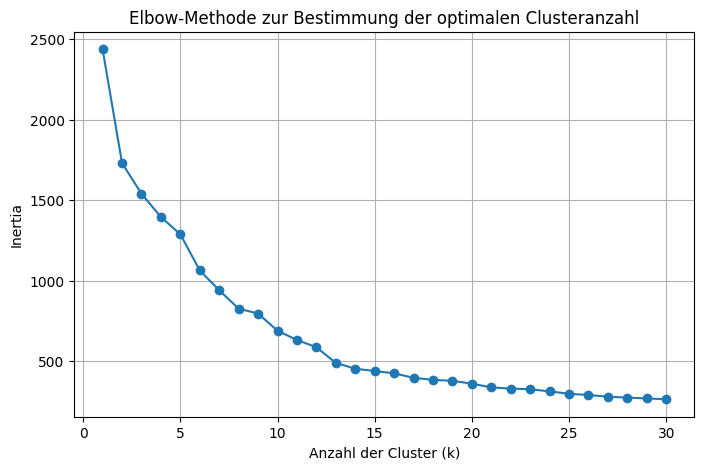

In [14]:
# Für verschiedene Clusterzahlen die "Inertia" berechnen

inertias = []
k_range = range(1, 31)  # z. B. 1 bis 30 Cluster

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot der Elbow-Kurve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Methode zur Bestimmung der optimalen Clusteranzahl')
plt.grid(True)
plt.show()


Die Elbow-Methode liefert kein eindeutiges Ergebnis. Im Datensatz sind mit Sicherheit noch echte Ausreißerstädte enhalten, die das Bild verzerren. Entscheidung: Mit 6 Clustern beginnen.

Als Algorithmus für die Zuordnung der Städte zu Clustern wird KMeans gewählt:

In [15]:
# KMeans mit 6 Clustern
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Clusterlabels zum ursprünglichen DataFrame hinzufügen
city_pollution_complete = city_pollution_avg.dropna().copy()
city_pollution_complete['Cluster'] = labels

# Vorschau: Welche Stadt gehört zu welchem Cluster?
print(city_pollution_complete[['Cluster']].value_counts().sort_index())


Cluster
0           73
1          182
2           82
3            1
4           67
5            1
Name: count, dtype: int64


Hier werden sofort extereme Outlier sichtbar: Cluster 3 und Cluster 5 enthalten jeweils nur eine Stadt.

Welche Städte wurden von KMeans als eigene Cluster bestimmt?

In [16]:
# Cluster mit nur 1 Stadt ermitteln
einzel_clusters = city_pollution_complete['Cluster'].value_counts()
einzel_clusters = einzel_clusters[einzel_clusters == 1].index.tolist()

# Städte aus diesen Clustern anzeigen
einzelstaedte = city_pollution_complete[city_pollution_complete['Cluster'].isin(einzel_clusters)]

print(einzelstaedte.index.tolist())  # Stadt-Namen


['Ashkelon', 'Temuco']


In [17]:
einzelstaedte

,Co,No2,O3,Pm10,Pm25,So2,Cluster
City,,,,,,,
Ashkelon,138.725000,4.882136,38.360179,34.591117,58.370522,1.113692,5
Temuco,5.965219,6.305758,1.466667,33.199499,67.521637,85.566667,3


## Städte mit extremen Schadstoffprofilen

### Temuco (Chile)
Temuco fällt durch außergewöhnlich hohe Schwefeldioxid-Werte (SO₂ ≈ 85.6 µg/m³) auf, die in keiner anderen Stadt annähernd erreicht wurden. Diese Belastung ist vermutlich auf die Kombination aus häufiger Holzverbrennung im Winter und der Nähe zum aktiven Vulkan Villarrica zurückzuführen. Auch die PM2.5-Werte lagen mit 67.5 µg/m³ deutlich über dem Mittel.

Aufgrund dieses sehr speziellen, aber durchaus plausiblen Luftschadstoffprofils hätte Temuco ein eigenes Cluster gebildet und dadurch die Vergleichbarkeit der übrigen Gruppen verzerrt. Die Stadt wurde daher aus der Clusteranalyse ausgeschlossen

### Ashkelon (Israel)
Ashkelon wurde aufgrund technischer Auffälligkeiten ausgeschlossen. Der CO-Wert liegt mit durchschnittlich 138.7 µg/m³ mehr als eine Größenordnung über allen anderen Städten im Datensatz. Auch die übrigen Schadstoffwerte wirken inkonsistent. Die stark abweichenden Werte deuten auf eine defekte oder fehlerhafte CO-Messstation hin.

Um eine Verzerrung der Clusteranalyse durch fehlerhafte Daten zu vermeiden, wurde Ashkelon entfernt. Der Ausschluss erfolgte hier nicht, um extreme, aber plausible Umweltbedingungen auszublenden, sondern auf Basis der Datenqualität.

In [18]:
# Liste der Städte, die aus der Hauptanalyse entfernt werden:
ausreisser = ['Ashkelon', 'Temuco']

# Neue Version des DataFrames ohne diese beiden
city_pollution_cleaned = city_pollution_complete.drop(index=ausreisser)

Nach der Entfernung von Ashkelon und Temuco wird die Clusteranalyse nach demselben Muster auf dem reduzierten Datensatz (df = city_pollution_scaled_cleaned) neu berechnet:

In [19]:
scaler = StandardScaler()
city_pollution_scaled_cleaned = scaler.fit_transform(city_pollution_cleaned)

In [20]:
kmeans_cleaned = KMeans(n_clusters=6, random_state=42)
labels_cleaned = kmeans_cleaned.fit_predict(city_pollution_scaled_cleaned)

# Clusterlabels zum DataFrame hinzufügen
city_pollution_cleaned['Cluster'] = labels_cleaned


In [21]:
city_pollution_cleaned['Cluster'].value_counts().sort_index()


Cluster
0     74
1    181
2      1
3     52
4     16
5     80
Name: count, dtype: int64

Wieder erscheint ein Cluster mit nur einer Stadt. Das ist nicht ungewöhnlich, da sich durch das Entfernen der extremen Ausreißer nun das gesamte Gefüge verschoben hat und nun auch weniger starke Ausreißer hervortreten können.

In [22]:
# Cluster mit nur 1 Stadt ermitteln
einzel_clusters = city_pollution_cleaned['Cluster'].value_counts()
einzel_clusters = einzel_clusters[einzel_clusters == 1].index.tolist()

# Städte aus diesen Clustern anzeigen
einzelstaedte = city_pollution_cleaned[city_pollution_cleaned['Cluster'].isin(einzel_clusters)]

print(einzelstaedte.index.tolist())  # Stadt-Namen

['Khorramshahr']


In [23]:
einzelstaedte

,Co,No2,O3,Pm10,Pm25,So2,Cluster
City,,,,,,,
Khorramshahr,25.591858,35.817337,112.714286,71.874381,91.864452,14.854658,2


### Khorramshahr (Iran)

Khorramshahr wurde aufgrund seines außergewöhnlich hohen Ozon- und Feinstaubniveaus aus der Hauptclusteranalyse ausgeschlossen. Die Werte deuten nicht auf Messfehler, sondern auf eine ernsthafte Luftbelastung hin, die möglicherweise durch regionale Industrieaktivität, hohe Temperaturen und Photochemie verstärkt wird.

Die Stadt bildet aufgrund ihres Extremprofils ein eigenes Cluster, wodurch die übrige Gruppierung verzerrt würde. Daher wird sie separat dokumentiert, aber aus der finalen Clusterstruktur ausgeschlossenn.

In [24]:
# Liste aktualisieren
ausreisser = ['Ashkelon', 'Temuco', 'Khorramshahr']

# Gefilterter DataFrame
X_cleaned_final = city_pollution_complete.drop(index=ausreisser)

Mit dem nun erhaltenen Datensatz (X_cleaned_final) wird die Clusteranalyse neu berechnet:

In [25]:
scaler = StandardScaler()
X_scaled_final = scaler.fit_transform(X_cleaned_final)


In [26]:
kmeans_final = KMeans(n_clusters=6, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled_final)

# Clusterlabels hinzufügen
X_cleaned_final['Cluster'] = labels_final


In [27]:
X_cleaned_final['Cluster'].value_counts().sort_index()

Cluster
0     51
1     35
2     17
3     74
4     80
5    146
Name: count, dtype: int64

Nun haben wir keine zu kleinen Cluster mehr. Die aktuelle Zuordnung wird also nicht weiter verändert.

Um zu sehen, ob und wie sich die Cluster bezüglich der Schadstoffwerte unterscheiden, werden als nächstes Boxplots erstellt. Da Boxplots die Verteilung jeweils einer Variablen anzeigen können, müssen Boxplots für jeden Schadstoff separat erstellt werden.

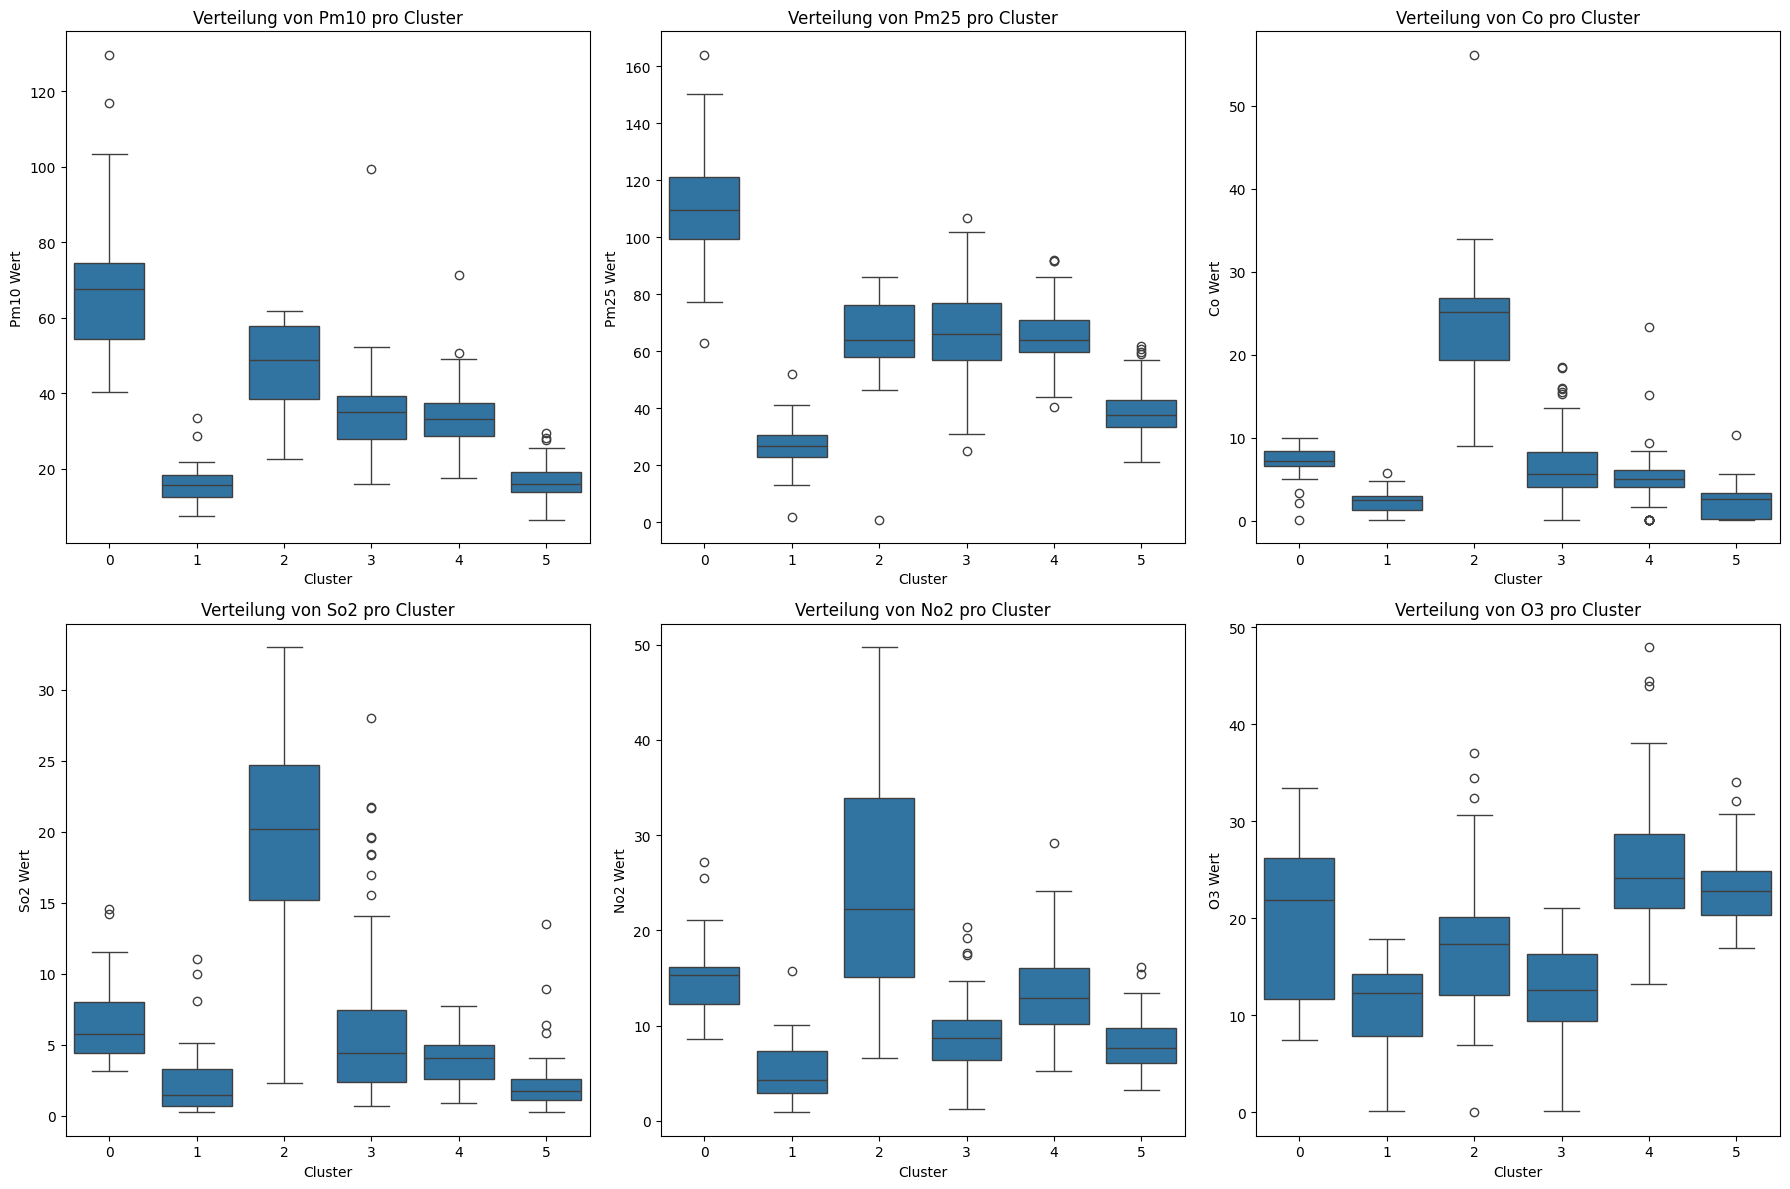

In [29]:
# Liste der Schadstoffe
pollutants = ['Pm10', 'Pm25', 'Co', 'So2', 'No2', 'O3']

# Erstelle die Boxplots für jeden Schadstoff
plt.figure(figsize=(18, 12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)  # 2 Zeilen, 3 Spalten für Boxplots
    sns.boxplot(x="Cluster", y=pollutant, data=X_cleaned_final)
    plt.xlabel("Cluster")
    plt.ylabel(f"{pollutant} Wert")
    plt.title(f"Verteilung von {pollutant} pro Cluster")

# Layout anpassen, um Überlappungen zu vermeiden
plt.tight_layout();


Zusätzlich ist es auch interessant zu sehen, wie sich die sechs Schadstoffe pro Cluster verteilen.

(ACHTUNG: Die Clusternummer sind durcheinander, also nicht einfach aufsteigend durchnummeriert!!!)

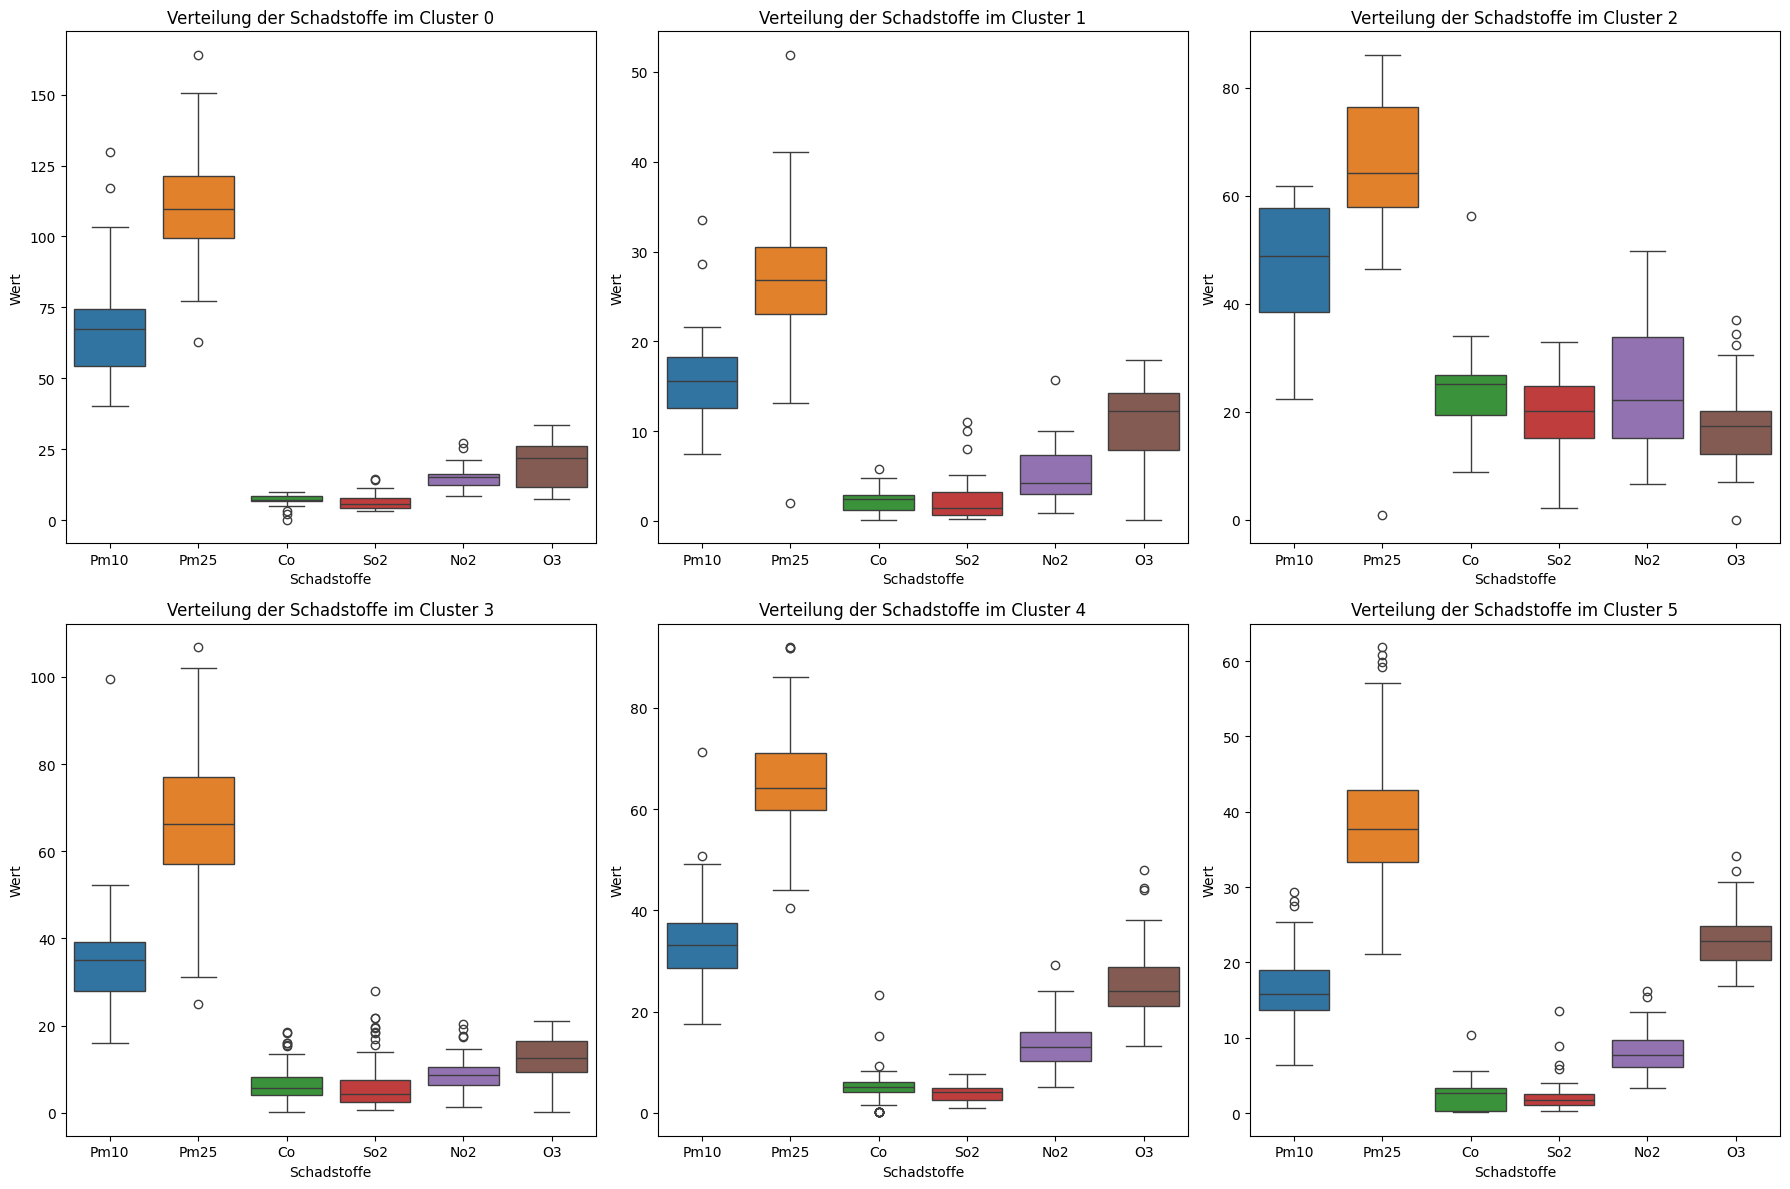

In [31]:
# Liste der Schadstoffe
pollutants = ['Pm10', 'Pm25', 'Co', 'So2', 'No2', 'O3']

# Erstelle die Boxplots pro Cluster
plt.figure(figsize=(18, 12))

# Finde die einzigartigen Cluster in den Daten und sortiere sie in aufsteigender Reihenfolge
clusters = sorted(X_cleaned_final['Cluster'].unique())

for i, cluster in enumerate(clusters, 1):
    plt.subplot(2, 3, i)  # 2 Zeilen, 3 Spalten für Boxplots
    
    # Filtere die Daten für das aktuelle Cluster
    cluster_data = X_cleaned_final[X_cleaned_final['Cluster'] == cluster]
    
    # Erstelle einen Boxplot für alle Schadstoffe im aktuellen Cluster
    sns.boxplot(data=cluster_data[pollutants])
    
    plt.title(f"Verteilung der Schadstoffe im Cluster {cluster}")
    plt.ylabel("Wert")
    plt.xlabel("Schadstoffe")

# Layout anpassen, um Überlappungen zu vermeiden
plt.tight_layout();



Da der Vergleich aller Boxplots auf einmal leicht unübersichtlich werden kann, führen wir im nächsten Schritt eine PCA durch, mit der die sechs Schadstoffe auf zwei Dimensionen reduziert werden. Diese sind zwar nicht mehr unmittelbar inhaltlich interpretierbar, geben mit Hilfe eines Scatterplots aber eine Antwort auf die Frage, ob die Cluster sich bezüglich ihrer Schadstoffprofile klar voneinander unterscheiden.

# 3. Clusterbeschreibung mit PCA

Als nächster Schritt überprüft werden, wie deutlich sich die Cluster in ihren Eigenschaften überschneiden. Dazu wird eine PCA durchgeführt, bei der die sechs Schadstoffe auf zwei Dimensionen reduziert werden, damit sie in einem zweidimensionalen Scatterplot darstellbar sind.

PS: Das hat jetzt nichts mit geografischer Verteilung zu tun, das zeigt nur, wie nah welche Cluster rechnerisch beieinander liegen.

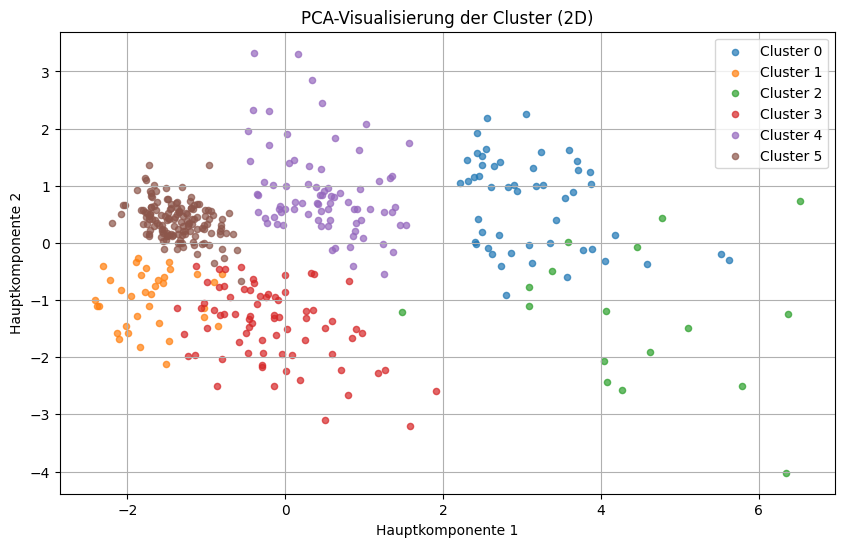

In [33]:
# PCA auf die skalierten Daten anwenden (X_scaled_final)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_final)

# In DataFrame mit Clusternummern zusammenführen
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_cleaned_final.index)
pca_df['Cluster'] = X_cleaned_final['Cluster']

# Plot definieren
plt.figure(figsize=(10, 6))
for cluster in sorted(pca_df['Cluster'].unique()):
    subset = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {cluster}', s=20, alpha=0.7)

plt.title("PCA-Visualisierung der Cluster (2D)")
plt.xlabel("Hauptkomponente 1")
plt.ylabel("Hauptkomponente 2")
plt.legend()
plt.grid(True);


Die PCA-Visualisierung zeigt die Verteilung der Städte im zweidimensionalen Raum, basierend auf ihren durchschnittlichen Schadstoffwerten (CO, NO₂, O₃, PM10, PM2.5, SO₂). Die ursprünglichen sechs Dimensionen wurden mithilfe einer Hauptkomponentenanalyse (PCA) auf zwei Hauptachsen reduziert, die möglichst viel der Varianz im Datensatz abbilden. Die Punkte im Plot repräsentieren einzelne Städte, eingefärbt nach ihrer jeweiligen Clusterzugehörigkeit (KMeans, k=6).

In der linken Hälfte des Plots gruppieren sich die Cluster 1, 3, 4 und 5:

- Cluster 5 erscheint besonders kompakt und dicht, was auf ein sehr homogenes Schadstoffprofil der zugehörigen Städte hindeutet.

- Cluster 1 und Cluster 3 liegen in direkter Nachbarschaft zu Cluster 5 und sind ebenfalls gut erkennbar voneinander abgegrenzt, jedoch weniger dicht. In einem kleinen Bereich überschneiden sich die drei Cluster leicht, was auf gewisse Ähnlichkeiten in den Profilen hindeutet.

- Cluster 4 liegt ebenfalls in der linken Plot-Hälfte, ist jedoch vollständig von den anderen Gruppen abgegrenzt. Die Punktwolke ist weniger dicht, aber klar umrissen, was auf größere interne Varianz, jedoch gute Abgrenzbarkeit hindeutet.

In der rechten Hälfte befinden sich Cluster 0 und Cluster 2:

- Cluster 0 bildet eine erkennbare Gruppe, überscheidet sich aber am Rand mit Cluster 2

- Cluster 2 ist das am stärksten gestreute Cluster und wirkt visuell weniger zusammenhängend. Ein einzelner Punkt liegt sogar deutlich entfernt in der linken Plothälfte, nahe bei Cluster 3. Die Zugehörigkeit zu Cluster 2 wird hier nur durch die algorithmische Einfärbung deutlich.

Die Clusterstruktur ist insgesamt ausreichend gut differenziert und bietet eine fundierte Grundlage für die inhaltliche Analyse der Luftverschmutzungsprofile.

# 4. Geographische Verteilung der Schadstoffcluster

Um zu verstehen, ob und wie Schadstoffmuster mit geographischer Lage zusammenhängen, werden die ermittelten Cluster nun auf eine Weltkarte geplottet.

In [32]:
# Mittelwerte der Schadstoffe je Cluster
cluster_profiles = X_cleaned_final.groupby('Cluster')[['Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2']].mean()

# Optional: auf 2 Dezimalstellen runden für bessere Lesbarkeit
cluster_profiles_rounded = cluster_profiles.round(2)

# Anzeigen
print(cluster_profiles_rounded)


            Co    No2     O3   Pm10    Pm25    So2
Cluster                                           
0         7.22  15.06  19.88  67.51  110.90   6.50
1         2.20   5.34  11.17  15.55   26.91   2.48
2        24.44  24.82  18.20  46.78   63.82  18.70
3         6.70   8.80  12.55  34.82   67.03   6.36
4         5.10  13.39  25.72  33.33   65.71   3.81
5         2.28   7.97  22.94  16.38   38.67   1.99


In [34]:
# Koordinaten zuordnen
coords = df.groupby('City')[['Latitude', 'Longitude']].mean()

# Nur die bereinigten Städte (ohne Ashkelon, Temuco, Khorramshahr)
coords_final = coords.loc[X_cleaned_final.index]

# GeoDataFrame bauen
coords_final['Cluster'] = X_cleaned_final['Cluster']
coords_final['geometry'] = coords_final.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf_final = gpd.GeoDataFrame(coords_final, geometry='geometry', crs='EPSG:4326')


In [35]:
# Farbdefinition individuell, weil die vorgegebenen Farbpaletten visuell schlecht zu unterscheiden waren, und weil man so die zugehörigen Cluster besser zuordnen kann
# Die hier gewählten Farben sollten für Präsentationen evtl. noch überarbeitet werden, weil das Rot_Grün-Problem weiter besteht.

cluster_colors = {
    1: '#4CAF50',  # mittelgrün
    5: '#1B5E20',  # dunkelgrün
    3: '#2196F3',  # mittelblau
    4: '#0D47A1',  # dunkelblau
    0: '#F7A1A1',  # hellrot
    2: '#B71C1C'   # dunkelrot
}

# Manuelle Gruppierung
legend_entries = [
    mpatches.Patch(color='#4CAF50', label='Cluster 1 – Niedrige Belastung (günstiges Klima)'),
    mpatches.Patch(color='#1B5E20', label='Cluster 5 – Niedrige Belastung (urbane Bedingungen)'),
    mpatches.Patch(color='#2196F3', label='Cluster 3 – Mittlere Belastung (Feinstaub)'),
    mpatches.Patch(color='#0D47A1', label='Cluster 4 – Mittlere Belastung (Ozon)'),
    mpatches.Patch(color='#F7A1A1', label='Cluster 0 – Starke Belastung (Feinstaub)'),
    mpatches.Patch(color='#B71C1C', label='Cluster 2 – Starke Belastung (CO und SO₂)')
]


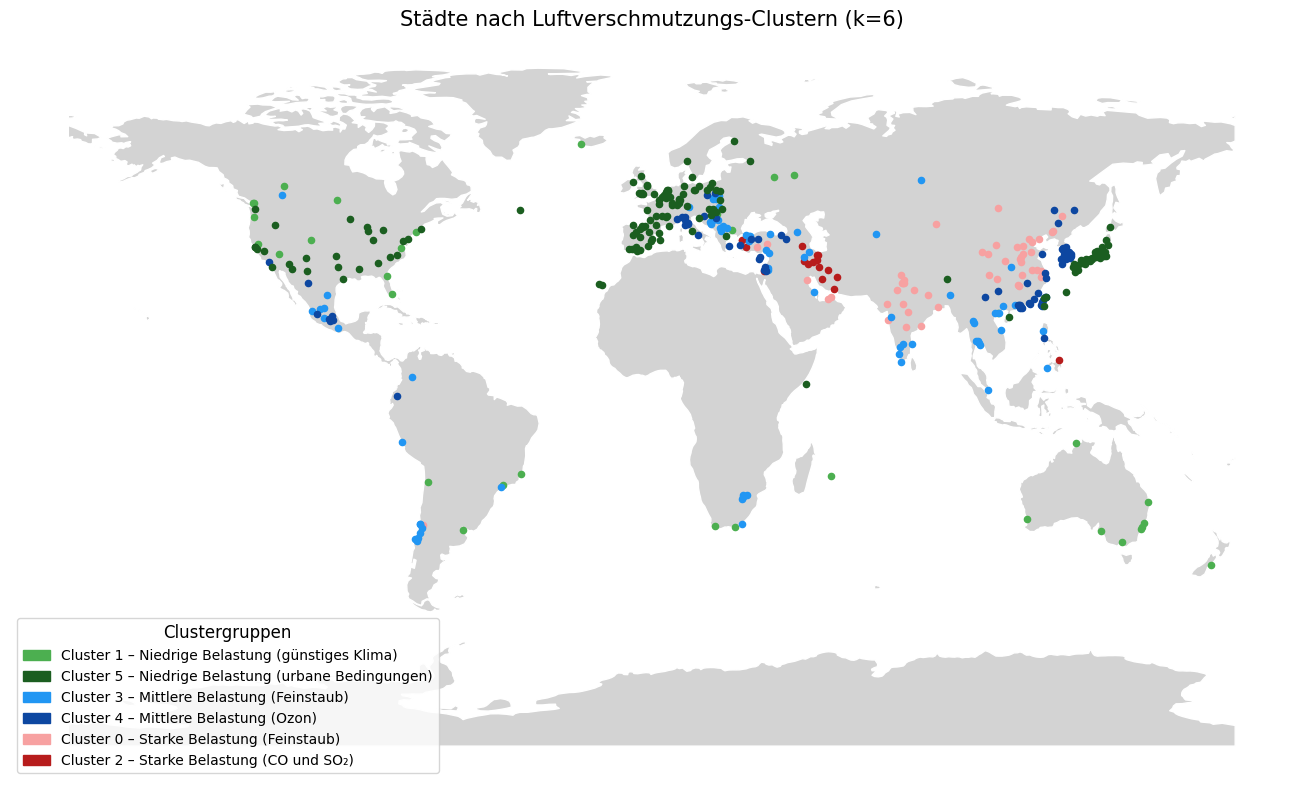

In [36]:
# Weltkarte
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# Punkte pro Cluster plotten
for cluster in sorted(gdf_final['Cluster'].unique()):
    gdf_final[gdf_final['Cluster'] == cluster].plot(
        ax=ax,
        color=cluster_colors[cluster],
        markersize=20,
        label=f'Cluster {cluster}'
    )

# Benutzerdefinierte Legende
ax.legend(handles=legend_entries, title="Clustergruppen", loc='lower left', fontsize=10, title_fontsize=12)

# Titel & Layout
ax.set_title("Städte nach Luftverschmutzungs-Clustern (k=6)", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()


# 5. Inhaltliche Interpretation

Abschließend werden die berechneten Cluster inhaltlich interpretiert.

Wir möchten an dieser Stelle darauf hinweisen, dass die Städte, die den Clustern mit niedriger Belastung zugeordnet wurden, mit Ausnahme von Zürich (Schweiz) alle die von der WHO aktuell empfohlenen Feinstaubwerte übersteigen. Es handelt also nur um *relativ* saubere Luft im Vergleich zu anderen Städten.

## Niedrige Schadstoffbelastung (Cluster 1 und 5)

Cluster 1 und Cluster 5 umfassen beide Städte mit insgesamt niedriger Luftverschmutzung. Dennoch unterscheidet der Algorithmus diese Gruppen aufgrund unterschiedlicher Schadstoffprofile, insbesondere bei Ozon (O₃) und Feinstaub (PM2.5).

Cluster 1 enthält vor allem Städte in Australien, Neuseeland, Kanada, Island und kleineren US-Regionen, oft in klimatisch günstigen, gut belüfteten oder dünn besiedelten Gegenden. Hier sind sowohl Ozon- als auch Feinstaubwerte durchgängig sehr niedrig. Die geringe Ozonbelastung ist besonders auffällig, da man intuitiv in Regionen wie Australien aufgrund des „Ozonlochs“ hohe Ozonwerte erwarten könnte. Tatsächlich bezieht sich das Ozonloch jedoch auf die Stratosphäre – bodennahes Ozon, das als Luftschadstoff wirkt, ist in diesen Städten gering.

Cluster 5 dagegen umfasst eine große Gruppe urbaner Zentren in Ländern wie Japan, Spanien, Frankreich, Deutschland, den USA und Großbritannien. Die Luftqualität ist hier weiterhin vergleichsweise gut, allerdings zeigen sich moderat erhöhte PM2.5- und Ozonwerte. Diese Belastungen lassen sich durch höhere Urbanisierung, Verkehrsdichte, sowie Photochemie in sonnenreichen Regionen erklären – insbesondere bei den Ozonwerten in südeuropäischen und japanischen Städten.

Die Trennung in zwei Cluster innerhalb der „sauberen Städte“ ist daher sachlich sinnvoll und differenzierend:
Cluster 1 steht für „sehr saubere Luft in klimatisch und strukturell begünstigten Regionen“,
Cluster 5 für „gute Luftqualität unter urbanen Rahmenbedingungen“.

In [37]:
# Schadstoffmittelwerte der beiden Cluster extrahieren, damit man sieht, wo sich die Städte trotz Ähnlichkeit unterscheiden
cluster_1 = cluster_profiles.loc[1]
cluster_5 = cluster_profiles.loc[5]

# Differenz berechnen
diff = (cluster_5 - cluster_1).round(2)
print(diff)

Co       0.07
No2      2.63
O3      11.77
Pm10     0.83
Pm25    11.76
So2     -0.50
dtype: float64


In [39]:
# Liste der Städte aus demselben Cluster speichern

# Cluster 1-Städte
cluster_1_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 1].index
cluster_1_info = df[df['City'].isin(cluster_1_staedte)][['City', 'Country', 'Population']]
cluster_1_info = cluster_1_info.drop_duplicates(subset='City').set_index('City')
cluster_1_info.to_csv('data/cluster_1_staedte.csv')

# Cluster 5-Städte
cluster_5_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 5].index
cluster_5_info = df[df['City'].isin(cluster_5_staedte)][['City', 'Country', 'Population']]
cluster_5_info = cluster_5_info.drop_duplicates(subset='City').set_index('City')
cluster_5_info.to_csv('data/cluster_5_staedte.csv')

## Mittlere Schadstoffbelastung (Cluster 3 und 4)

Cluster 3 und Cluster 4 umfassen Städte mit moderater Luftbelastung, unterscheiden sich jedoch in ihrer dominierenden Schadstoffzusammensetzung und regionalen Verteilung.

Cluster 3 vereint Städte mit leicht erhöhter Feinstaubbelastung (PM2.5, PM10) sowie etwas höheren Werten bei CO und SO₂. Diese Belastungskonstellation weist auf gemischte Emissionsquellen wie Hausbrand, Industrie und Verkehr hin. Geografisch liegen die Städte überwiegend in Süd- und Südostasien, Lateinamerika, der Türkei und Südafrika – also Regionen mit teils unvollständiger Filtertechnik und wachsender Urbanisierung.

Cluster 4 dagegen ist geprägt durch erhöhte Ozon- und NO₂-Werte, bei insgesamt geringerer Partikelbelastung. Diese Konstellation ist typisch für Städte mit starker Verkehrsdichte und intensiver Photochemie, etwa in sonnigen, urbanen Küstenregionen oder dicht besiedelten Stadtstaaten. Cluster 4 umfasst hauptsächlich Städte in Südkorea, Taiwan, China, Mexiko und Südeuropa.

Die Trennung dieser beiden Cluster ist daher gut begründet: Cluster 3 steht für eine diffuse, partikelgetriebene Belastung, während Cluster 4 eher für verkehrsbedingte Ozonbildung und Stickstoffoxidbelastung steht – also unterschiedliche urbane Luftbelastungsmodelle mit verschiedenen Ursachen und Lösungsansätzen.

In [40]:
# Schadstoffmittelwerte der beiden Cluster extrahieren, damit man sieht, wo sich die Städte trotz Ähnlichkeit unterscheiden
diff_3_4 = (cluster_profiles.loc[3] - cluster_profiles.loc[4]).round(2)
print(diff_3_4)

Co       1.59
No2     -4.60
O3     -13.18
Pm10     1.49
Pm25     1.32
So2      2.55
dtype: float64


In [41]:
# Liste der Städte aus demselben Cluster speichern

# Cluster 3-Städte
cluster_3_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 3].index
cluster_3_info = df[df['City'].isin(cluster_3_staedte)][['City', 'Country', 'Population']]
cluster_3_info = cluster_3_info.drop_duplicates(subset='City').set_index('City')
cluster_3_info.to_csv('data/cluster_3_staedte.csv')

# Cluster 4-Städte
cluster_4_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 4].index
cluster_4_info = df[df['City'].isin(cluster_4_staedte)][['City', 'Country', 'Population']]
cluster_4_info = cluster_4_info.drop_duplicates(subset='City').set_index('City')
cluster_4_info.to_csv('data/cluster_4_staedte.csv')

## Hohe Schadstoffbelastung (Cluster 0 und 2)

Cluster 0 und Cluster 2 umfassen Städte mit insgesamt sehr hoher Luftverschmutzung, unterscheiden sich jedoch deutlich in der Art der dominierenden Schadstoffe.

Cluster 0 ist geprägt von extrem hohen Feinstaubwerten (PM2.5 und PM10), während die Konzentrationen gasförmiger Schadstoffe wie Kohlenmonoxid (CO), Stickstoffdioxid (NO₂) und Schwefeldioxid (SO₂) vergleichsweise niedriger ausfallen. Diese Belastung ist typisch für viele schnell wachsende Megastädte, wie sie in China, Indien und angrenzenden Regionen zu finden sind. Häufige Ursachen sind Hausbrand, industrielle Emissionen, ungünstige Wetterlagen und hohe Bevölkerungsdichte.

Cluster 2 hingegen weist sehr hohe Konzentrationen gasförmiger Luftschadstoffe auf – insbesondere CO und SO₂ –, während die Feinstaubwerte zwar erhöht, aber deutlich geringer sind als in Cluster 0. Die Städte in Cluster 2 liegen überwiegend im Iran und in der Türkei, mit vereinzelten Städten in Israel und Südostasien. Die Belastung in diesen Regionen dürfte vor allem auf verkehrs- und energiebedingte Emissionen, veraltete Infrastruktur und industrielle Verbrennungsprozesse zurückzuführen sein.

Die Trennung dieser beiden Cluster ist daher inhaltlich gut nachvollziehbar: Cluster 0 steht für partikelgetriebene Belastung, Cluster 2 für eine gasförmige Emissionsdominanz. Beide stellen gesundheitlich bedenkliche Situationen dar, aber mit unterschiedlichen Quellenprofilen, die jeweils spezifische Gegenmaßnahmen erfordern würden.

In [42]:
# Schadstoffmittelwerte der beiden Cluster extrahieren, damit man sieht, wo sich die Städte trotz Ähnlichkeit unterscheiden
diff_0_2 = (cluster_profiles.loc[0] - cluster_profiles.loc[2]).round(2)
print(diff_0_2)

Co     -17.22
No2     -9.76
O3       1.68
Pm10    20.73
Pm25    47.08
So2    -12.20
dtype: float64


In [43]:
# Liste der Städte aus demselben Cluster speichern

# Cluster 0-Städte
cluster_0_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 0].index
cluster_0_info = df[df['City'].isin(cluster_0_staedte)][['City', 'Country', 'Population']]
cluster_0_info = cluster_0_info.drop_duplicates(subset='City').set_index('City')
cluster_0_info.to_csv('data/cluster_0_staedte.csv')

# Cluster 2-Städte
cluster_2_staedte = X_cleaned_final[X_cleaned_final['Cluster'] == 2].index
cluster_2_info = df[df['City'].isin(cluster_2_staedte)][['City', 'Country', 'Population']]
cluster_2_info = cluster_2_info.drop_duplicates(subset='City').set_index('City')
cluster_2_info.to_csv('data/cluster_2_staedte.csv')

### Übersichtstabelle

Für eine Präsentation ist die Interpretation der Cluster hier noch einmal als Tabelle zusammengefasst:

In [44]:
# Übersichtstabelle erstellen
data = {
    "Cluster": ["1", "5", "4", "3", "2", "0"],
    "Belastungsprofil": [
        "Sehr saubere Luft",
        "Saubere Luft, urban geprägt",
        "Ozon- & NO₂-betonte Belastung",
        "Partikelbetonte Mischung",
        "Gasdominierte Belastung",
        "Extreme Feinstaubbelastung"
    ],
    "Hauptschadstoffe": [
        "keine dominant",
        "O₃, PM2.5",
        "O₃, NO₂",
        "PM2.5, CO, SO₂",
        "CO, SO₂, NO₂",
        "PM2.5, PM10"
    ],
    "Regionale Tendenz": [
        "Australien, Neuseeland, Kanada",
        "Europa, Japan, USA",
        "Südkorea, Taiwan, Südeuropa",
        "Südostasien, Südafrika, Mexiko",
        "Iran, Türkei, Israel",
        "China, Indien, VAE"
    ],
    "Mögliche Ursachen": [
        "Geringe Emissionen, gute Durchlüftung",
        "Verkehr, Photochemie, urbane Dichte",
        "Verkehr, Sonne, hohe Bevölkerungsdichte",
        "Hausbrand, lokale Industrie, gemischte Quellen",
        "Verkehr, fossile Energie, Industrieabgase",
        "Industrie, Hausbrand, Inversion, Urbanisierung"
    ]
}

df_overview = pd.DataFrame(data)

df_overview

,Cluster,Belastungsprofil,Hauptschadstoffe,Regionale Tendenz,Mögliche Ursachen
0,1,Sehr saubere Luft,keine dominant,"Australien, Neuseeland, Kanada","Geringe Emissionen, gute Durchlüftung"
1,5,"Saubere Luft, urban geprägt","O₃, PM2.5","Europa, Japan, USA","Verkehr, Photochemie, urbane Dichte"
2,4,Ozon- & NO₂-betonte Belastung,"O₃, NO₂","Südkorea, Taiwan, Südeuropa","Verkehr, Sonne, hohe Bevölkerungsdichte"
3,3,Partikelbetonte Mischung,"PM2.5, CO, SO₂","Südostasien, Südafrika, Mexiko","Hausbrand, lokale Industrie, gemischte Quellen"
4,2,Gasdominierte Belastung,"CO, SO₂, NO₂","Iran, Türkei, Israel","Verkehr, fossile Energie, Industrieabgase"
5,0,Extreme Feinstaubbelastung,"PM2.5, PM10","China, Indien, VAE","Industrie, Hausbrand, Inversion, Urbanisierung"
